In [1]:
# Switch to tensorflow 1.x
%tensorflow_version 1.x

UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
from Compute_Jacobian import jacobian # Please download 'Compute_Jacobian.py' in the repository 
import numpy as np
import timeit
from scipy.interpolate import griddata
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y


In [4]:
class PINN:
    # Initialize the class
    def __init__(self, layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size):
        # Normalization 
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]

        # Samplers
        self.operator = operator
        self.ics_sampler = ics_sampler
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler

        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)
        
        # weights
        self.lam_u_val = np.array(1.0)
        self.lam_ut_val = np.array(1.0)
        self.lam_r_val = np.array(1.0)
      
        # Wave constant
        self.c = tf.constant(c, dtype=tf.float32)
        
        self.kernel_size = kernel_size # Size of the NTK matrix

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # Define placeholders and computational graph
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.u_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        
        self.lam_u_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        self.lam_ut_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        self.lam_r_tf = tf.placeholder(tf.float32, shape=self.lam_u_val.shape)
        

        # Define placeholders for NTK computation
        D1 = self.kernel_size    # boundary
        D2 = self.kernel_size    # ut   
        D3 = self.kernel_size    # residual  D1 = D3 = 3D2

        self.t_u_ntk_tf = tf.placeholder(tf.float32, shape=(D1, 1))
        self.x_u_ntk_tf = tf.placeholder(tf.float32, shape=(D1, 1))
        
        self.t_ut_ntk_tf = tf.placeholder(tf.float32, shape=(D2, 1))
        self.x_ut_ntk_tf = tf.placeholder(tf.float32, shape=(D2, 1))
        
        self.t_r_ntk_tf = tf.placeholder(tf.float32, shape=(D3, 1))
        self.x_r_ntk_tf = tf.placeholder(tf.float32, shape=(D3, 1))

        # Evaluate predictions
        self.u_ics_pred = self.net_u(self.t_ics_tf, self.x_ics_tf)
        self.u_t_ics_pred = self.net_u_t(self.t_ics_tf, self.x_ics_tf)
        self.u_bc1_pred = self.net_u(self.t_bc1_tf, self.x_bc1_tf)
        self.u_bc2_pred = self.net_u(self.t_bc2_tf, self.x_bc2_tf)

        self.u_pred = self.net_u(self.t_u_tf, self.x_u_tf)
        self.r_pred = self.net_r(self.t_r_tf, self.x_r_tf)
        
        # Define predictions for NTK computation
        self.u_ntk_pred = self.net_u(self.t_u_ntk_tf, self.x_u_ntk_tf)
        self.ut_ntk_pred = self.net_u_t(self.t_ut_ntk_tf, self.x_ut_ntk_tf)
        self.r_ntk_pred = self.net_r(self.t_r_ntk_tf, self.x_r_ntk_tf)

        # Boundary loss and Initial loss
        self.loss_ics_u = tf.reduce_mean(tf.square(self.u_ics_tf - self.u_ics_pred))
        self.loss_ics_u_t = tf.reduce_mean(tf.square(self.u_t_ics_pred))
        self.loss_bc1 = tf.reduce_mean(tf.square(self.u_bc1_pred))
        self.loss_bc2 = tf.reduce_mean(tf.square(self.u_bc2_pred))

        self.loss_bcs = self.loss_ics_u + self.loss_bc1 + self.loss_bc2

        # Residual loss
        self.loss_res = tf.reduce_mean(tf.square(self.r_pred))

        # Total loss
        self.loss = self.lam_r_tf * self.loss_res + self.lam_u_tf * self.loss_bcs + self.lam_ut_tf * self.loss_ics_u_t 

        # Define optimizer with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        # Logger
        self.loss_bcs_log = []
        self.loss_ut_ics_log = []
        self.loss_res_log = []
        self.saver = tf.train.Saver()
        
        # Compute the Jacobian for weights and biases in each hidden layer  
        self.J_u = self.compute_jacobian(self.u_ntk_pred)
        self.J_ut = self.compute_jacobian(self.ut_ntk_pred)
        self.J_r = self.compute_jacobian(self.r_ntk_pred)
        
        self.K_u = self.compute_ntk(self.J_u, D1, self.J_u, D1)
        self.K_ut = self.compute_ntk(self.J_ut, D2, self.J_ut, D2)
        self.K_r = self.compute_ntk(self.J_r, D3, self.J_r, D3)
        
        # NTK logger 
        self.K_u_log = []
        self.K_ut_log = []
        self.K_r_log = []
        
        # weights logger
        self.lam_u_log = []
        self.lam_ut_log = []
        self.lam_r_log = []
        
         # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                               dtype=tf.float32)

        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    # Evaluates the forward pass
    def forward_pass(self, H, layers, weights, biases):
        num_layers = len(layers)
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    # Forward pass for u
    def net_u(self, t, x):
        u = self.forward_pass(tf.concat([t, x], 1),
                              self.layers,
                              self.weights,
                              self.biases)
        return u

    # Forward pass for du/dt
    def net_u_t(self, t, x):
        u_t = tf.gradients(self.net_u(t, x), t)[0] / self.sigma_t
        return u_t

    # Forward pass for the residual
    def net_r(self, t, x):
        u = self.net_u(t, x)
        residual = self.operator(u, t, x,
                                 self.c,
                                 self.sigma_t,
                                 self.sigma_x)
        return residual
    
    
    # Compute Jacobian for each weights and biases in each layer and retrun a list 
    def compute_jacobian(self, f):
        J_list =[]
        L = len(self.weights)    
        for i in range(L):
            J_w = jacobian(f, self.weights[i])
            J_list.append(J_w)
     
        for i in range(L):
            J_b = jacobian(f, self.biases[i])
            J_list.append(J_b)
        return J_list
    
    # Compute the empirical NTK = J J^T
    def compute_ntk(self, J1_list, D1, J2_list, D2):

        N = len(J1_list)
        
        Ker = tf.zeros((D1,D2))
        for k in range(N):
            J1 = tf.reshape(J1_list[k], shape=(D1,-1))
            J2 = tf.reshape(J2_list[k], shape=(D2,-1))
            
            K = tf.matmul(J1, tf.transpose(J2))
            Ker = Ker + K
        return Ker

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

        # Trains the model by minimizing the MSE loss

    def train(self, nIter=10000, batch_size=128, log_NTK=False, update_lam=False):

        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size // 3)
            X_bc1_batch, _ = self.fetch_minibatch(self.bcs_sampler[0], batch_size // 3)
            X_bc2_batch, _ = self.fetch_minibatch(self.bcs_sampler[1], batch_size // 3)
            
            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                       self.u_ics_tf: u_ics_batch,
                       self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                       self.t_bc2_tf: X_bc2_batch[:, 0:1], self.x_bc2_tf: X_bc2_batch[:, 1:2],
                       self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2],
                       self.lam_u_tf: self.lam_u_val,
                       self.lam_ut_tf: self.lam_ut_val,
                       self.lam_r_tf: self.lam_r_val}

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time

                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value = self.sess.run(self.loss_bcs, tf_dict)
                loss_ics_ut_value = self.sess.run(self.loss_ics_u_t, tf_dict)
                loss_res_value = self.sess.run(self.loss_res, tf_dict)

                # Store losses
                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_res_log.append(loss_res_value)
                self.loss_ut_ics_log.append(loss_ics_ut_value)

                print('It: %d, Loss: %.3e, Loss_res: %.3e,  Loss_bcs: %.3e, Loss_ut_ics: %.3e,, Time: %.2f' %
                      (it, loss_value, loss_res_value, loss_bcs_value, loss_ics_ut_value, elapsed))
                
                print('lambda_u: {:.3e}'.format(self.lam_u_val))
                print('lambda_ut: {:.3e}'.format(self.lam_ut_val))
                print('lambda_r: {:.3e}'.format(self.lam_r_val))

                start_time = timeit.default_timer()
            
          
            if log_NTK:
                if it % 100 == 0:
                        print("Compute NTK...")
                        X_bc_batch = np.vstack([X_ics_batch, X_bc1_batch, X_bc2_batch])
                        X_ics_batch, u_ics_batch = self.fetch_minibatch(self.ics_sampler, batch_size )

                        tf_dict = {self.t_u_ntk_tf: X_bc_batch[:,0:1], self.x_u_ntk_tf: X_bc_batch[:, 1:2],
                                   self.t_ut_ntk_tf: X_ics_batch[:,0:1], self.x_ut_ntk_tf: X_ics_batch[:, 1:2],
                                   self.t_r_ntk_tf: X_res_batch[:,0:1], self.x_r_ntk_tf: X_res_batch[:, 1:2]}
                        
                        K_u_value, K_ut_value, K_r_value =  self.sess.run([self.K_u, self.K_ut, self.K_r], tf_dict)
                        
                        trace_K = np.trace(K_u_value) + np.trace(K_ut_value) + \
                                       np.trace(K_r_value)

                        # Store NTK matrices
                        self.K_u_log.append(K_u_value)
                        self.K_ut_log.append(K_ut_value)
                        self.K_r_log.append(K_r_value)
                        
                        if update_lam:

                          self.lam_u_val = trace_K / np.trace(K_u_value)
                          self.lam_ut_val = trace_K /np.trace(K_ut_value)
                          self.lam_r_val = trace_K / np.trace(K_r_value)

                          # Store NTK weights
                          self.lam_u_log.append(self.lam_u_val)
                          self.lam_ut_log.append(self.lam_ut_val)
                          self.lam_r_log.append(self.lam_r_val)
                        
                        
          
    # Evaluates predictions at test points
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 0:1], self.x_u_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        return u_star

        # Evaluates predictions at test points

    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_r_tf: X_star[:, 0:1], self.x_r_tf: X_star[:, 1:2]}
        r_star = self.sess.run(self.r_pred, tf_dict)
        return r_star

In [5]:
# Define the exact solution and its derivatives
def u(x, a, c):
    """
    exact solution
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    
    return np.exp(-x**2/2*a**2) * np.cos(2*np.pi*x) * np.exp(-(2*np.pi)**2*2*c*t)
    
    #return np.sin(np.pi * x) * np.cos(c * np.pi * t) + \
    #a * np.sin(2 * c * np.pi* x) * np.cos(4 * c  * np.pi * t)

def u_t(x,a, c):
    # first derivitive of t
    t = x[:,0:1]
    x = x[:,1:2]
    u_t = -np.exp(-x**2/2*a**2) * np.cos(2*np.pi*x) * (2*np.pi)**2*c * np.exp(-(2*np.pi)**2*c*t)
    return u_t

def u_tt(x, a, c):
    # second derivitive of t
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = np.exp(-x**2/2*a**2) * np.cos(2*np.pi*x) * (2*np.pi)**4*c**2 * np.exp(-(2*np.pi)**2*c*t)


    return u_tt

def u_xx(x, a, c):
    # second derivitive of x
    t = x[:,0:1]
    x = x[:,1:2]
    u_xx = - np.pi**2 * np.sin( np.pi * x) * np.cos(c * np.pi * t) - \
              a * (2 * c * np.pi)** 2 * np.sin(2 * c * np.pi* x) * np.cos(4 * c * np.pi * t)
    return  u_xx


def r(x, a, c):
    # THE pde its selft
    return u_tt(x, a, c) - c**2 * u_xx(x, a, c)

def operator(u, t, x, c, sigma_t=1.0, sigma_x=1.0):
    # gradient
    u_t = tf.gradients(u, t)[0] / sigma_t
    u_x = tf.gradients(u, x)[0] / sigma_x
    u_tt = tf.gradients(u_t, t)[0] / sigma_t
    u_xx = tf.gradients(u_x, x)[0] / sigma_x
    residual = u_tt - c**2 * u_xx
    return residual

In [15]:
# Define the exact solution and its derivatives
def u(x, a, c):
    """
    exact solution
    :param x: x = (t, x)
    """
    t = x[:,0:1]
    x = x[:,1:2]
    
    return np.cos(a*(np.pi)*x)*np.exp(-c*(a*np.pi)**2*t)
    
    #return np.sin(np.pi * x) * np.cos(c * np.pi * t) + \
    #a * np.sin(2 * c * np.pi* x) * np.cos(4 * c  * np.pi * t)

def u_t(x,a, c):
    # first derivitive of t
    t = x[:,0:1]
    x = x[:,1:2]
    u_t = np.cos(a*(np.pi)*x)*(-c*(a*np.pi)**2)*np.exp(-c*(a*np.pi)**2*t)
    return u_t

def u_tt(x, a, c):
    # second derivitive of t
    t = x[:,0:1]
    x = x[:,1:2]
    u_tt = -c*(a*np.pi)**2*np.cos(a*(np.pi)*x)*(-c*(a*np.pi)**2)*np.exp(-c*(a*np.pi)**2*t)
    return u_tt

def u_xx(x, a, c):
    # second derivitive of x
    t = x[:,0:1]
    x = x[:,1:2]
    
    u_xx = -np.exp(-x**2/2*a**2) * (np.cos(2*np.pi*x) * (2*np.pi)**2\
            + np.sin(2*np.pi*x) * (2*np.pi)**3*x/a**2) * np.exp(-(2*np.pi)**2*c*t)
    return  u_xx

def u_x(x,a,c):
    t = x[:,0:1]
    x = x[:,1:2]
    return (-x/a**2) * np.exp(-x**2/2*a**2) * np.cos(2*np.pi*x) * np.exp(-(2*np.pi)**2*c*t) - \
(2*np.pi) * np.exp(-x**2/2*a**2) * np.sin(2*np.pi*x) * np.exp(-(2*np.pi)**2*c*t)


def r(x, a, c):
    # THE pde its selft
    return u_tt(x, a, c)+u(x,a,c)*u_x(x,a,x) - c * u_xx(x, a, c)

def operator(u, t, x, c, sigma_t=1.0, sigma_x=1.0):
    # gradient
    u_t = tf.gradients(u, t)[0] / sigma_t
    u_x = tf.gradients(u, x)[0] / sigma_x
    u_tt = tf.gradients(u_t, t)[0] / sigma_t
    u_xx = tf.gradients(u_x, x)[0] / sigma_x
    residual = u_tt - u*u_x-c* u_xx
    return residual

In [16]:
# Domain boundaries
ics_coords = np.array([[0.0, 0.0],
                        [0.0, 1.0]])
bc1_coords = np.array([[0.0, 0.0],
                        [1.0, 0.0]])
bc2_coords = np.array([[0.0, 1.0],
                        [1.0, 1.0]])
dom_coords = np.array([[0.0, 0.0],
                        [1.0, 1.0]])

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), name='Initial Condition 1')

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), name='Dirichlet BC1')
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), name='Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), name='Forcing')

In [17]:
# Define PINN model
a = 0.5
c = 2

layers = [2, 500, 500, 500, 1]
kernel_size = 300
model = PINN(layers, operator, ics_sampler, bcs_sampler, res_sampler, c, kernel_size)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Device mapping:



2023-03-28 09:37:20.744080: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 09:37:20.745782: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.
2023-03-28 09:37:21.850262: E tensorflow/core/common_runtime/executor.cc:642] Executor failed to create kernel. Internal: No function library
	 [[{{node loop_body/gradients/MatMul_24_grad/MatMul_1/pfor/cond}}]]
2023-03-28 09:37:21.921306: E tensorflow/core/common_runtime/executor.cc:642] Executor failed to create kernel. Internal: No function library
	 [[{{node loop_body_1/gradients/MatMul_25_grad/MatMul_1/pfor/cond}}]]
2023-03-28 09:37:21.979730: E tensorflow/core/c

Device mapping: no known devices.
random_normal/RandomStandardNormal: (RandomStandardNormal): /job:localhost/replica:0/task:0/device:CPU:0
random_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
random_normal: (Add): /job:localhost/replica:0/task:0/device:CPU:0
mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
Variable/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/IsInitialized/VarIsInitializedOp: (VarIsInitializedOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (AssignVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Read/ReadVariableOp: (ReadVariableOp): /job:localhost/replica:0/task:0/device:CPU:0
random_normal_1/RandomStandardNormal: (RandomStandardNormal): /job:localhost/replica:0/tas

/placer.cc:54] loop_body_13/gradients/truediv_5_grad/RealDiv_1: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-28 09:37:28.221293: I tensorflow/core/common_runtime/placer.cc:54] loop_body_13/gradients/truediv_5_grad/RealDiv_2: (RealDiv): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-28 09:37:28.221305: I tensorflow/core/common_runtime/placer.cc:54] loop_body_13/gradients/truediv_5_grad/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-28 09:37:28.221317: I tensorflow/core/common_runtime/placer.cc:54] loop_body_13/gradients/truediv_5_grad/Sum_1: (Sum): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-28 09:37:28.222032: I tensorflow/core/common_runtime/placer.cc:54] loop_body_13/gradients/truediv_5_grad/Reshape_1: (Reshape): /job:localhost/replica:0/task:0/device:CPU:0
2023-03-28 09:37:28.222049: I tensorflow/core/common_runtime/placer.cc:54] loop_body_13/gradients/gradients_5/concat_7_grad/Slice_grad/stack: (Pack): /job:localhost/replica:0/tas

In [20]:
# Train model
itertaions = 1000
log_NTK = False # Compute and store NTK matrix during training
update_lam = True # Compute and update the loss weights using the NTK 

model.train(nIter=itertaions, batch_size=kernel_size, log_NTK=log_NTK, update_lam=update_lam)

It: 0, Loss: 3.100e-01, Loss_res: 3.444e-04,  Loss_bcs: 2.787e-01, Loss_ut_ics: 3.093e-02,, Time: 0.15
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 100, Loss: 2.189e-01, Loss_res: 7.006e-03,  Loss_bcs: 1.969e-01, Loss_ut_ics: 1.499e-02,, Time: 18.17
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 200, Loss: 1.684e-01, Loss_res: 8.436e-03,  Loss_bcs: 1.530e-01, Loss_ut_ics: 7.027e-03,, Time: 18.46
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 300, Loss: 1.538e-01, Loss_res: 5.448e-03,  Loss_bcs: 1.343e-01, Loss_ut_ics: 1.413e-02,, Time: 18.47
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 400, Loss: 1.592e-01, Loss_res: 2.668e-02,  Loss_bcs: 1.282e-01, Loss_ut_ics: 4.334e-03,, Time: 18.60
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
It: 500, Loss: 1.415e-01, Loss_res: 1.124e-02,  Loss_bcs: 1.263e-01, Loss_ut_ics: 3.956e-03,, Time: 18.80
lambda_u: 1.000e+00
lambda_ut: 1.000e+00
lambda_r: 1.000e+00
I

**Training Loss**

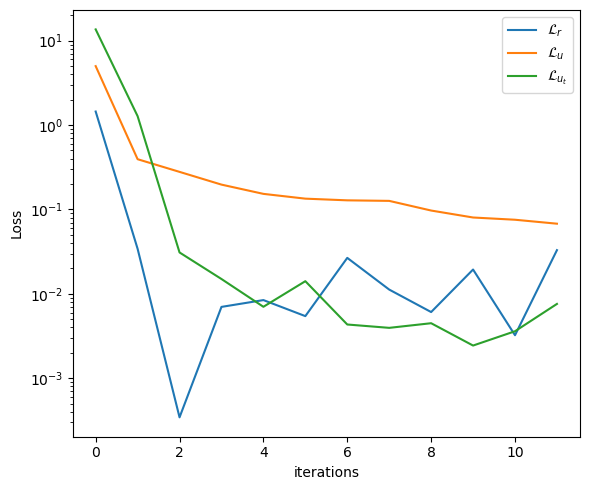

In [21]:
loss_res = model.loss_res_log
loss_bcs = model.loss_bcs_log
loss_u_t_ics = model.loss_ut_ics_log

fig = plt.figure(figsize=(6, 5))
plt.plot(loss_res, label='$\mathcal{L}_{r}$')
plt.plot(loss_bcs, label='$\mathcal{L}_{u}$')
plt.plot(loss_u_t_ics, label='$\mathcal{L}_{u_t}$')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

**Model Prediction**

In [24]:
nn = 200
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn)[:, None]
t, x = np.meshgrid(t, x)
X_star = np.hstack((t.flatten()[:, None], x.flatten()[:, None]))

u_star = u(X_star, a,c)
R_star = r(X_star, a, c)

# Predictions
u_pred = model.predict_u(X_star)
r_pred = model.predict_r(X_star)
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 1.399332e+00


In [25]:
U_star = griddata(X_star, u_star.flatten(), (t, x), method='cubic')
R_star = griddata(X_star, R_star.flatten(), (t, x), method='cubic')
U_pred = griddata(X_star, u_pred.flatten(), (t, x), method='cubic')
R_pred = griddata(X_star, r_pred.flatten(), (t, x), method='cubic')


plt.figure(figsize=(18, 9))
plt.subplot(2, 3, 1)
plt.pcolor(t, x, U_star, cmap='jet')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Exact u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 2)
plt.pcolor(t, x, U_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted u(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 3)
plt.pcolor(t, x, np.abs(U_star - U_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()

plt.subplot(2, 3, 4)
plt.pcolor(t, x, R_star, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 5)
plt.pcolor(t, x, R_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted r(t, x)')
plt.tight_layout()

plt.subplot(2, 3, 6)
plt.pcolor(t, x, np.abs(R_star - R_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

ValueError: different number of values and points

**NTK Eigenvalues**

In [ ]:
# Create empty lists for storing the eigenvalues of NTK
lam_K_u_log = []
lam_K_ut_log = []
lam_K_r_log = []

# Restore the NTK
K_u_list = model.K_u_log
K_ut_list = model.K_ut_log
K_r_list = model.K_r_log

K_list = []
    
for k in range(len(K_u_list)):
    K_u = K_u_list[k]
    K_ut = K_ut_list[k]
    K_r = K_r_list[k]
    
    # Compute eigenvalues
    lam_K_u, _ = np.linalg.eig(K_u)
    lam_K_ut, _ = np.linalg.eig(K_ut)
    lam_K_r, _ = np.linalg.eig(K_r)
    # Sort in descresing order
    lam_K_u = np.sort(np.real(lam_K_u))[::-1]
    lam_K_ut = np.sort(np.real(lam_K_ut))[::-1]
    lam_K_r = np.sort(np.real(lam_K_r))[::-1]
    
    # Store eigenvalues
    lam_K_u_log.append(lam_K_u)
    lam_K_ut_log.append(lam_K_ut)
    lam_K_r_log.append(lam_K_r)

In [ ]:
#  Eigenvalues of NTK
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)

plt.plot(lam_K_u_log[0], label = '$n=0$')
plt.plot(lam_K_u_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_u_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_u_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')

plt.title(r'Eigenvalues of ${K}_u$')

plt.subplot(1,3,2)
plt.plot(lam_K_ut_log[0], label = '$n=0$')
plt.plot(lam_K_ut_log[1], '--',label = '$n=10,000$')
plt.plot(lam_K_ut_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_ut_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{u_t}$')

ax =plt.subplot(1,3,3)
plt.plot(lam_K_r_log[0], label = '$n=0$')
plt.plot(lam_K_r_log[1], '--', label = '$n=10,000$')
plt.plot(lam_K_r_log[4], '--', label = '$n=40,000$')
plt.plot(lam_K_r_log[-1], '--', label = '$n=80,000$')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Eigenvalues of ${K}_{r}$')
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", bbox_to_anchor=(0.35, -0.02),
            borderaxespad=0, bbox_transform=fig.transFigure, ncol=4)
plt.tight_layout()
plt.show()

**Evolution of NTK Weights**

In [ ]:
if update_lam == True:

  lam_u_log = model.lam_u_log
  lam_ut_log = model.lam_ut_log
  lam_r_log = model.lam_r_log

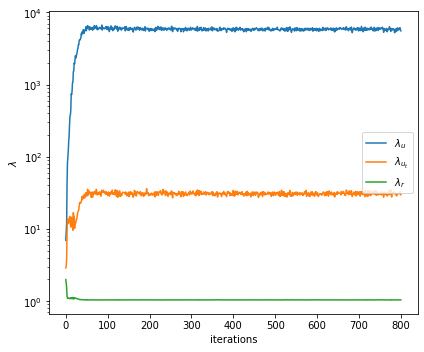

In [ ]:
fig = plt.figure(figsize=(6, 5))
plt.plot(lam_u_log, label='$\lambda_u$')
plt.plot(lam_ut_log, label='$\lambda_{u_t}$')
plt.plot(lam_r_log, label='$\lambda_{r}$')
plt.xlabel('iterations')
plt.ylabel('$\lambda$')
plt.yscale('log')
plt.legend( )
plt.tight_layout()
plt.show()